# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. В рамках исследования требуется построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

*Признаки*
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

*Целевой признак*
* Price — цена (евро)

## Подготовка данных

### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from numpy import *
import re
from time import time

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter('ignore')

pd.set_option('display.max_rows', None, 'display.max_columns', None)

print('Setup Complete')

Setup Complete


In [2]:
try:
    df = pd.read_csv('autos.csv')
    
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
def descriptive_statistics(df):
    display(df.head())
    print(df.info())
    print(round(df.isna().sum()/len(df)*100,2))
    print(df.describe().T)
    print('\nДубликаты:', df.duplicated().sum())

In [4]:
descriptive_statistics(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Выводы**:
* В данных 354 тысячи строк, 16 признаков, из которых "Price" - целевой.
* Целевой признак количественный, поэтому решаться будет задача регрессии. 
* 5 признаков сожержат пропущенные значения от 5 до 20 %.
* Признаки с датами нужно привести к типу datetime.
* Обнаружены 4 полных дубликата.
* Имеются выбросы и аномальные значения: подробнее посмотрим на них на этапе исследовательского анализа.
* Все значени признака "NumberOfPictures" равны нулю, поэтому его можно удалить.
* Потребуется привести названия колонок к "змеиному" регистру.

### Предобработка данных

*Название колонок*

In [5]:
columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)

In [6]:
df.columns = columns
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

*Изменение типа данных с датами*

In [7]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

*Удаляем полные дубликаты*

In [9]:
df = df.drop_duplicates(ignore_index=True)

### Исследовательский анализ данных

**Поочередно исследуем каждый признак: начнем с целевого признака - Price**

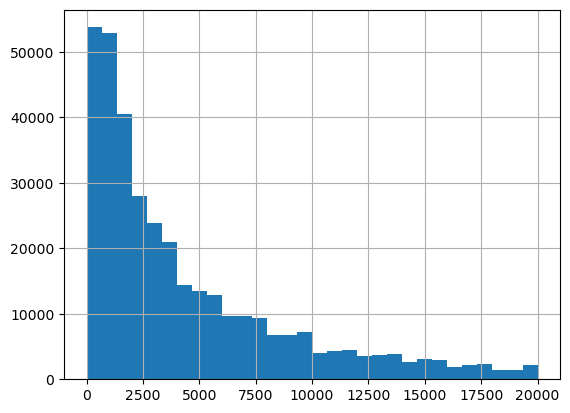

In [10]:
df['price'].hist(bins=30);

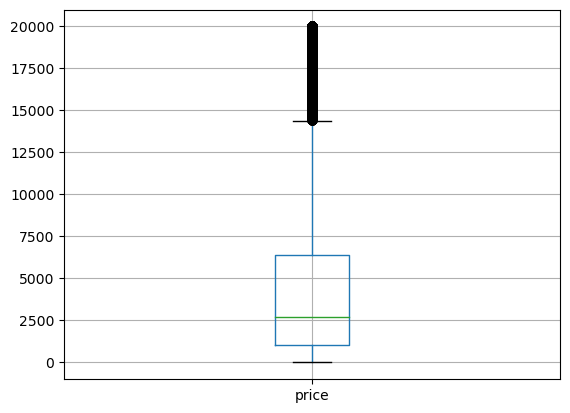

In [11]:
df.boxplot('price');

Удаляем строки со значениями цены равной нулю

In [12]:
df = df[df['price']>0]

Большинство автомобилей продается по цене от 1000 до 6500 евро. Максимальная цена 20 тысяч евро. Эти данные похожи на реальные.

**Дата скачивания анкеты из базы**

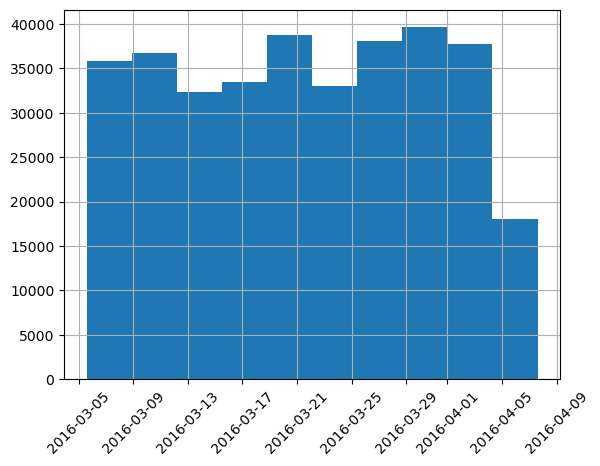

In [13]:
df['date_crawled'].hist(xrot=45);

Анкеты были скачаны в марте-апреле 2016 года. Эти данные неважны для анализа: колонку удалим перед обучением моделей.

**Год регистрации автомобиля**

In [14]:
df['registration_year'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: registration_year, dtype: float64

Имеются аномальные значения: например, 1000 или 9999. Ограничимся периодом между 1940 и 2016 годами.

In [15]:
df = df[(df['registration_year'] > 1940) & (df['registration_year'] <= 2016)]

Добавим колонку с возрастом автомобиля

In [16]:
df['car_age'] = df['last_seen'].dt.year - df['registration_year']

In [17]:
df['car_age'].describe()

count    329655.000000
mean         13.380204
std           6.769698
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          75.000000
Name: car_age, dtype: float64

Большинство автомобилей возрастом 13 лет. Максимальный возраст 75 лет.

**Модель**

In [18]:
df['model'].isna().sum()

15590

In [19]:
len(df['model'].unique())

251

Более 15 тысяч пропусков. Всего представлено 251 модель автомобилей. Заполним отсутствующие значения "заглушкой".

In [20]:
df['model'].fillna('unknown', inplace=True) 

**Тип автомобильного кузова**

In [21]:
df['vehicle_type'].value_counts(dropna=False)

sedan          89379
small          78000
wagon          63695
bus            28341
NaN            19897
convertible    19853
coupe          15629
suv            11789
other           3072
Name: vehicle_type, dtype: int64

Почти 20 тысяч пропуков. Заполним отсутствующие значения наиболее часто встречающимися с группировкой по бренду и модели автомобиля.

In [22]:
df['vehicle_type'] = df.groupby(['model','brand'], sort=False)['vehicle_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))

**Тип коробки передач**

In [23]:
df['gearbox'].value_counts(dropna=False)

manual    251106
auto       62999
NaN        15550
Name: gearbox, dtype: int64

Большинство автомобилей с ручной коробкой передач. Заполним отсутствующие значения наиболее часто встречающимися с группировкой по модели автомобиля.

In [24]:
df['gearbox'] = df.groupby(['model'], sort=False)['gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0]))

**Мощность (л. с.)**

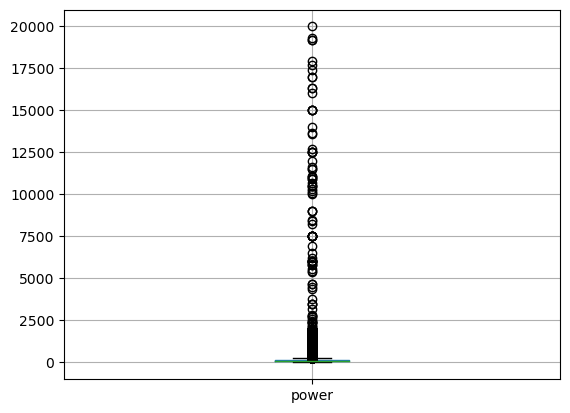

In [25]:
df.boxplot('power');

Оставим значения с мощностью до 700 (исходя из значений 3 квартили и стандартного отклонения) лошадиных сил.

In [26]:
df = df[df['power']<700]

In [27]:
df['power'][df['power']==0].count()

32793

Нулевых значений значительное количество. Преобразуем их в Nan для дальнейшей замены.

In [28]:
df.loc[df['power'] == 0, 'power'] = np.nan

Отсутствующие значения заменим на медианные с группировкой по брэндам и возрасту автомобиля.

In [29]:
df['power'] = df.groupby(['brand','car_age'])['power'].apply(lambda x: x.fillna(x.median()))

In [30]:
df['power'].isna().sum()

115

Оставшиеся отсутствующие значения удалим.

In [31]:
df = df.dropna(subset=['power'], axis=0)

**Пробег**

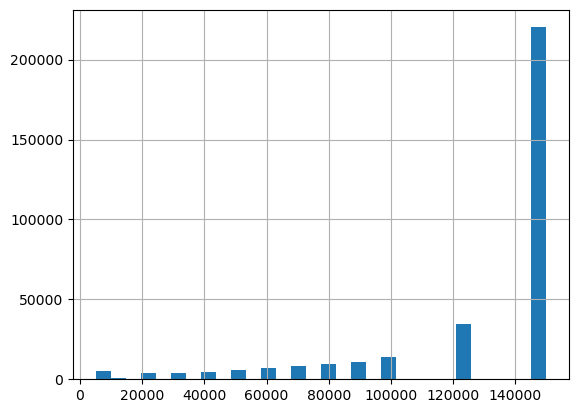

In [32]:
df['kilometer'].hist(bins=30);

Большинство автомобилей имеют пробег около 15000 километров.

**Месяц регистрации автомобиля**

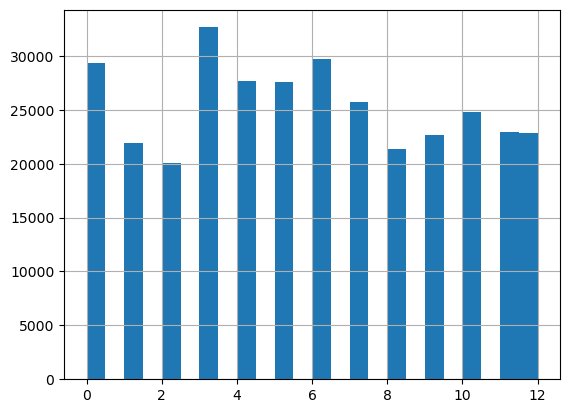

In [33]:
df['registration_month'].hist(bins=24);

Каждый месяц регистрируется примерно одинаковое количество автомобилей. Данный признак не влияет на цену, поэтому его удалим перед обучением моделей.

**Тип топлива**

In [34]:
df['fuel_type'].value_counts(dropna=False)

petrol      204419
gasoline     94772
NaN          24030
lpg           5020
cng            531
hybrid         220
other          160
electric        86
Name: fuel_type, dtype: int64

Самое большое количество машин на бензиновом двигателе. Отсутствующих значений 24 тысячи. Заполним их "заглушкой"

In [35]:
df['fuel_type'].fillna('unknown', inplace=True) 

**Марка автомобиля**

In [36]:
len(df['brand'].unique())

40

Всего представлено 40 марок автомобилей. Посмотрим на топ 10 самых распространенных на рынке.

In [37]:
df['brand'].value_counts().head(10)

volkswagen       70745
opel             36632
bmw              34720
mercedes_benz    30312
audi             27620
ford             23460
renault          16407
peugeot          10411
fiat              8861
seat              6350
Name: brand, dtype: int64

**Была машина в ремонте или нет**

In [38]:
df['repaired'].value_counts(dropna=False)

no     236696
NaN     59648
yes     32894
Name: repaired, dtype: int64

Большинство машин не были в ремонте. Заполним отсутствующие значения ответом "no", т.к. скорее всего пользователь забыл указать, что машина не была в ремонте.

In [39]:
df['repaired'].fillna('no', inplace=True)

**Дата создания анкеты**

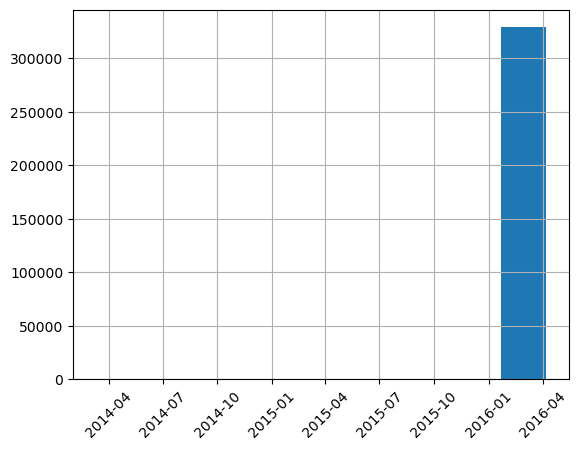

In [40]:
df['date_created'].hist(xrot=45);

Большинство анкет созданы в 2016 году

In [41]:
df['date_created'][df['date_created'].dt.year < 2016].count()

26

Только 26 анкет были созданы до 2016 года: в 2014 и 2015 годах.

**Почтовый индекс владельца анкеты (пользователя)**

In [42]:
len(df['postal_code'].unique())

8133

Почтовых индексов более 8 тысяч: то есть пользователи в выборке из большого количества городов.

**Дата последней активности пользователя**

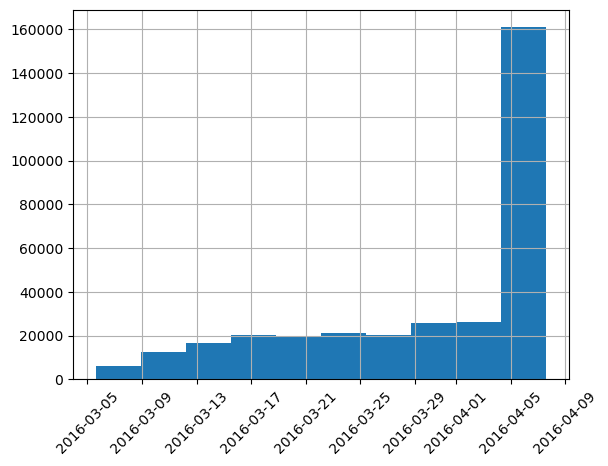

In [43]:
df['last_seen'].hist(xrot=45);

В целом все пользователи активны на период составления базы: март-апрель 2016 года.

**Удаляем ненужные столбцы**

In [44]:
df = df.drop(['date_crawled','last_seen', 'number_of_pictures', 'registration_month', 
              'date_created', 'registration_year'], axis=1)

Убедимся, что все отсутствующие значения заполнены.

In [45]:
df.isna().sum()

price           0
vehicle_type    0
gearbox         0
power           0
model           0
kilometer       0
fuel_type       0
brand           0
repaired        0
postal_code     0
car_age         0
dtype: int64

**Построим матрицу диаграмм рассеяния, чтобы посмотреть на наличие взаимосвязей между признаками**

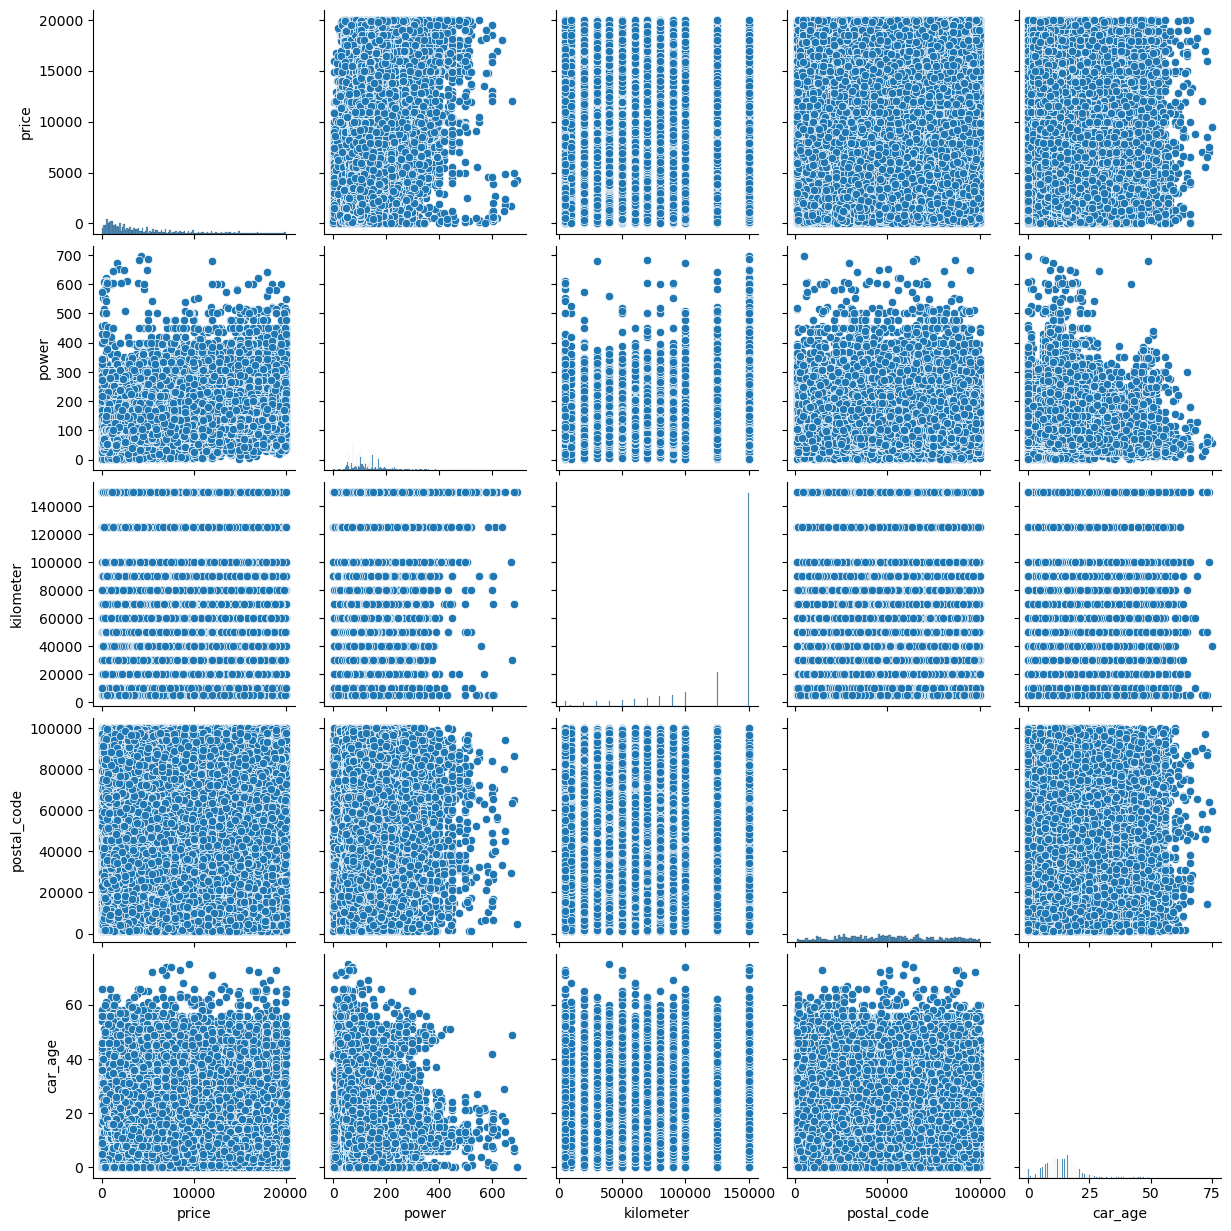

In [46]:
sns.pairplot(data=df);

Явных зависимостей между признаками на графике невидно: приступим к обучению моделей.

## Обучение моделей

### Создание обучающей, валидационной и тестовой выборок

In [48]:
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical_features = ['power', 'kilometer', 'postal_code', 'car_age']

In [49]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=12345)

Убедимся, что разбивка на выборки выполнена верно.

In [51]:
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)
print('y_test', y_test.shape)

X_train (197542, 10)
X_valid (65848, 10)
X_test (65848, 10)
y_train (197542,)
y_valid (65848,)
y_test (65848,)


### Масштабирование признаков

In [52]:
sc = StandardScaler()
X_train[numerical_features] = sc.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = sc.transform(X_valid[numerical_features])
X_test[numerical_features] = sc.transform(X_test[numerical_features])

### Кодирование категориальных признаков

In [53]:
# прямое кодирование (для линейных моделей)
X_train_ohe = pd.get_dummies(X_train, drop_first=True)
X_valid_ohe = pd.get_dummies(X_valid, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(X_train_ohe.columns) & set(X_valid_ohe.columns) & set(X_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
X_train_ohe = X_train_ohe[list(common_columns)]
X_valid_ohe = X_valid_ohe[list(common_columns)]
X_test_ohe = X_test_ohe[list(common_columns)]

In [54]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
encoder.fit(X_train[categorical_features])

X_train_ord = X_train.copy()
X_valid_ord = X_valid.copy()
X_test_ord = X_test.copy()

X_train_ord[categorical_features] = encoder.transform(X_train_ord[categorical_features])
X_valid_ord[categorical_features] = encoder.transform(X_valid_ord[categorical_features])
X_test_ord[categorical_features] = encoder.transform(X_test_ord[categorical_features])

### Обучение моделей

#### LinearRegression

In [55]:
LR = LinearRegression()
start = time()
LR.fit(X_train_ohe, y_train)
end = time()
LR_fit_time = end - start

start = time()
y_pred = LR.predict(X_valid_ohe)
end = time()
LR_predict_time = end - start

LR_rmse = mean_squared_error(y_valid, y_pred) ** 0.5
LR_rmse

2727.369897629254

#### RandomForestRegressor

In [56]:
RF = RandomForestRegressor(random_state=12345)

start = time()
RF.fit(X_train_ord, y_train)
end = time()
RF_fit_time = end - start

start = time()
y_pred = RF.predict(X_valid_ord)
end = time()
RF_predict_time = end - start

RF_rmse = mean_squared_error(y_valid, y_pred) ** 0.5
RF_rmse

1649.6053444553374

**Подбор гиперпараметров**

In [57]:
params = []
for estim in [100,500]:
    for depth in [10,100]:
        RF = RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth=depth)
        
        start = time()
        RF.fit(X_train_ord, y_train)
        end = time()
        RF_fit_time_select = end - start
        
        start = time()
        y_pred = RF.predict(X_valid_ord)
        end = time()
        RF_predict_time_select = end - start
        
        RF_rmse_select = mean_squared_error(y_valid, y_pred) ** 0.5
        params.append(
            {
                'n_estimators': estim,
                'max_depth': depth,
                'RF_rmse_select':  RF_rmse_select,
                'RF_fit_time_select': RF_fit_time_select,
                'RF_predict_time_select': RF_predict_time_select
            }
        )
best_param = pd.DataFrame(params).nsmallest(1, ['RF_rmse_select'], keep='first')
RF_rmse_best = best_param['RF_rmse_select'].values
RF_fit_time_best = best_param['RF_fit_time_select'].values
RF_predict_time_best = best_param['RF_predict_time_select'].values

best_param

,n_estimators,max_depth,RF_rmse_select,RF_fit_time_select,RF_predict_time_select
3,500,100,1642.325879,594.625659,87.429874


#### XGBRegressor

In [58]:
XGB = XGBRegressor(random_state=12345,n_jobs=-1)

start = time()
XGB.fit(X_train_ord, y_train)
end = time()
XGB_fit_time = end - start

start = time()
y_pred = XGB.predict(X_valid_ord)
end = time()
XGB_predict_time = end - start

XGB_rmse = mean_squared_error(y_valid, y_pred) ** 0.5
XGB_rmse

1690.307565636676

**Подбор гиперпараметров**

In [59]:
params = []
for estim in [100, 500]:
    for depth in [5, 10]:
        XGB = XGBRegressor(random_state=12345, n_estimators=estim, 
                                       max_depth=depth, n_jobs=-1)
        start = time()
        XGB.fit(X_train_ord, y_train)
        end = time()
        XGB_fit_time_select = end - start
        
        start = time()
        y_pred = XGB.predict(X_valid_ord)
        end = time()
        XGB_predict_time_select = end - start
        
        XGB_rmse_select = mean_squared_error(y_valid, y_pred) ** 0.5
        params.append(
                        {
                            'n_estimators': estim,
                            'max_depth': depth,
                            'XGB_rmse_select':  XGB_rmse_select,
                            'XGB_fit_time_select': XGB_fit_time_select,
                            'XGB_predict_time_select': XGB_predict_time_select
                        }
                    )

best_param = pd.DataFrame(params).nsmallest(1, ['XGB_rmse_select'], keep='first')
XGB_rmse_best = best_param['XGB_rmse_select'].values
XGB_fit_time_best = best_param['XGB_fit_time_select'].values
XGB_predict_time_best = best_param['XGB_predict_time_select'].values

best_param

,n_estimators,max_depth,XGB_rmse_select,XGB_fit_time_select,XGB_predict_time_select
1,100,10,1637.113341,10.325217,0.074005


#### LightGBMRegressor

In [60]:
X_train_LGBM = X_train
X_valid_LGBM = X_valid
X_train_LGBM[categorical_features] = X_train_LGBM[categorical_features].astype('category')
X_valid_LGBM[categorical_features] = X_valid_LGBM[categorical_features].astype('category')

In [61]:
LGB = LGBMRegressor(random_state=12345)

start = time()
LGB.fit(X_train_LGBM, y_train)
end = time()
LGB_fit_time = end - start

start = time()
y_pred = LGB.predict(X_valid_LGBM)
end = time()
LGB_predict_time = end - start

LGB_rmse = mean_squared_error(y_valid, y_pred) ** 0.5
LGB_rmse

1683.8862827749188

**Подбор гиперпараметров**

In [62]:
params = []
for estim in [100, 500]:
    for depth in [5, 10]:
        LGB = LGBMRegressor(random_state=12345, n_estimators=estim, 
                                       max_depth=depth)
        start = time()
        LGB.fit(X_train_LGBM, y_train)
        end = time()
        LGB_fit_time_select = end - start
        
        start = time()
        y_pred = LGB.predict(X_valid_LGBM)
        end = time()
        LGB_predict_time_select = end - start
        
        LGB_rmse_select = mean_squared_error(y_valid, y_pred) ** 0.5
        params.append(
            {
                 'n_estimators': estim,
                  'max_depth': depth,
                  'LGB_rmse_select':  LGB_rmse_select,
                  'LGB_fit_time_select': LGB_fit_time_select,
                  'LGB_predict_time_select': LGB_predict_time_select
                        }
                    )

best_param = pd.DataFrame(params).nsmallest(1, ['LGB_rmse_select'], keep='first')
LGB_rmse_best = best_param['LGB_rmse_select'].values
LGB_fit_time_best = best_param['LGB_fit_time_select'].values
LGB_predict_time_best = best_param['LGB_predict_time_select'].values

best_param

,n_estimators,max_depth,LGB_rmse_select,LGB_fit_time_select,LGB_predict_time_select
3,500,10,1619.896377,2.053125,0.464033


#### CatBoostRegressor

In [63]:
CB = CatBoostRegressor(random_state=12345,verbose=0, cat_features=categorical_features)

start = time()
CB.fit(X_train, y_train)
end = time()
CB_fit_time = end - start

start = time()
y_pred = CB.predict(X_valid)
end = time()
CB_predict_time = end - start

CB_rmse = mean_squared_error(y_valid, y_pred) ** 0.5
CB_rmse

1663.0184116250234

**Подбор гиперпараметров**

In [64]:
params = []
for iterations in [100,500,1000]:
    for depth in [5,10]:
        CB = CatBoostRegressor(random_state=12345, iterations=iterations, 
                                       depth=depth, verbose=0, cat_features=categorical_features)
        start = time()
        CB.fit(X_train, y_train)
        end = time()
        CB_fit_time_select = end - start
        
        start = time()
        y_pred = CB.predict(X_valid)
        end = time()
        CB_predict_time_select = end - start
        
        CB_rmse_select = mean_squared_error(y_valid, y_pred) ** 0.5
        params.append(
            {
                            'iterations': iterations,
                            'depth': depth,
                            'CB_rmse_select':  CB_rmse_select,
                            'CB_fit_time_select': CB_fit_time_select,
                            'CB_predict_time_select': CB_predict_time_select
                        }
                    )

best_param = pd.DataFrame(params).nsmallest(1, ['CB_rmse_select'], keep='first')
CB_rmse_best = best_param['CB_rmse_select'].values
CB_fit_time_best = best_param['CB_fit_time_select'].values
CB_predict_time_best = best_param['CB_predict_time_select'].values

best_param

,iterations,depth,CB_rmse_select,CB_fit_time_select,CB_predict_time_select
5,1000,10,1606.421988,232.82379,0.411027


## Анализ моделей

### Сравнение метрики качества и времени

In [65]:
models = pd.DataFrame({
    'Model': ['LR', 'RF_base', 'XGB_base', 'LGB_base', 'CB_base', 
             'RF_best', 'XGB_best', 'LGB_best', 'CB_best'],
    'RMSE': [LR_rmse, RF_rmse, XGB_rmse, LGB_rmse, CB_rmse,
             RF_rmse_best, XGB_rmse_best, LGB_rmse_best, CB_rmse_best],
    'Fit_time': [LR_fit_time, RF_fit_time, XGB_fit_time, LGB_fit_time, CB_fit_time, RF_fit_time_best,
             XGB_fit_time_best, LGB_fit_time_best, CB_fit_time_best],
    'Predict_time': [LR_predict_time, RF_predict_time, XGB_predict_time, LGB_predict_time, CB_predict_time, 
                     RF_predict_time_best, XGB_predict_time_best, LGB_predict_time_best, CB_predict_time_best]})

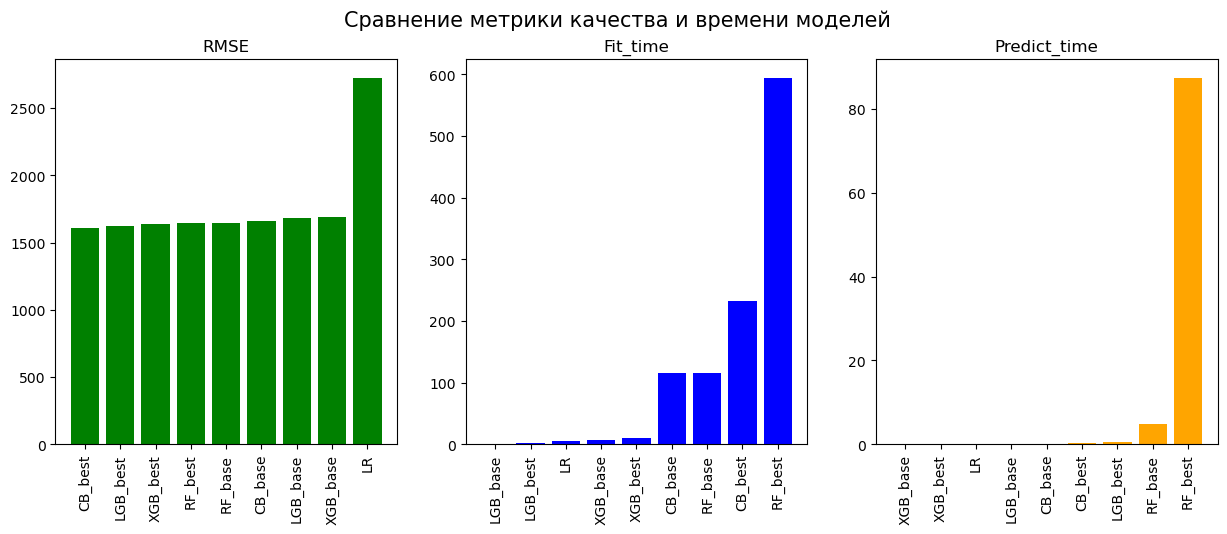

In [66]:
fig, axs = plt.subplots(1,3,figsize=(15,5)) 
fig.suptitle('Сравнение метрики качества и времени моделей', fontsize=15)

labels = models.sort_values(by='RMSE')['Model']
values = models.sort_values(by='RMSE')['RMSE']
axs[0].bar(labels, values, color = 'g')
axs[0].set_xticklabels(labels, rotation='vertical')
axs[0].set_title('RMSE')

labels = models.sort_values(by='Fit_time')['Model']
values = models.sort_values(by='Fit_time')['Fit_time']
axs[1].bar(labels, values, color = 'b')
axs[1].set_xticklabels(labels, rotation='vertical')
axs[1].set_title('Fit_time')

labels = models.sort_values(by='Predict_time')['Model']
values = models.sort_values(by='Predict_time')['Predict_time']
axs[2].bar(labels, values, color = 'orange')
axs[2].set_xticklabels(labels, rotation='vertical')
axs[2].set_title('Predict_time');

**Вывод**   
У CatBoost и XGB наилучшие результаты метрики качества. Оценка RandomForest близка к ним, но время обучения и прогнозирования очень велико. Разница между метрикой качества XGB и CatBoost не очень значительна, но при этом CatBoost намного быстрее. Основываясь на сочетании всех трех факторов, делаем вывод, что предпочтительно использовать CatBoost в качестве окончательной модели.

### Проверка модели на тестовой выборке

Теперь проверим значения метрики качества на тестовой выборке.

In [67]:
CB = CatBoostRegressor(random_state=12345, iterations=1000, 
                                       depth=10, verbose=0, cat_features=categorical_features)
CB.fit(X_train, y_train)
y_pred = CB.predict(X_test)
CB_rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
CB_rmse_test

1589.962480784667

Метрики качества на валидацинной и тестовой выборке близки друг к другу: переобучения не наблюдается.

Увеличим обучающий набор данных, заново разбив датасет на выборки.

In [68]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [69]:
X_train[numerical_features] = sc.fit_transform(X_train[numerical_features])
X_test[numerical_features] = sc.transform(X_test[numerical_features])

In [70]:
# прямое кодирование (для линейных моделей)
X_train_ohe = pd.get_dummies(X_train, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, drop_first=True)

common_columns = set(X_train_ohe.columns) & set(X_test_ohe.columns)

X_train_ohe = X_train_ohe[list(common_columns)]
X_test_ohe = X_test_ohe[list(common_columns)]

In [71]:
CB_final = CatBoostRegressor(random_state=12345, iterations=1000, 
                                       depth=10, verbose=0, cat_features=categorical_features)
start = time()
CB_final.fit(X_train, y_train)
end = time()
fit_time_final = end - start

start = time()
y_pred = CB_final.predict(X_test)
end = time()
predict_time_final = end - start

CB_rmse_final = mean_squared_error(y_test, y_pred) ** 0.5
print('RMSE, eur:', round(CB_rmse_final,0))
print('Fit time, sec:', round(fit_time_final,0))
print('Predict time, sec:', round(predict_time_final,2))

RMSE, eur: 1575.0
Fit time, sec: 318.0
Predict time, sec: 0.79


#### Проверка на вменяемость

В качестве тривиальной модели возьмем линейную регрессию. Затем сравним ее метрику качества с метрикой выбранной модели.

In [72]:
LR = LinearRegression()
LR.fit(X_train_ohe, y_train)
y_pred = LR.predict(X_test_ohe)
LR_rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
LR_rmse_test

2730.7825823193193

In [73]:
round((LR_rmse_test-CB_rmse_final)/LR_rmse_test * 100, 2)

42.33

## Вывод

Целью этого проекта была разработка модели для определения рыночной стоимости автомобиля на основе исторических данных. Модель должна была иметь высокую метрику качества RMSE и высокую скорость обучения и прогнозирования.

**Для выполнения задания были выполнены следующие шаги:**

1. **Описательная статистика**: найдены пропущенные значения, неверный формат признаков с датами, 6 категориальных признаков, возможные выбросы в нескольких переменных.
2. **Предварительная обработка данных**: преобразоны имена столбцов в "змеиный" регистр, изменен тип данных, удалены дубликаты.
3. **Исследовательский анализ данных**: проанализированы все признаки, в том числе, заполнены пропуски, удалены выбросы и аномальные значения, создан признак "возраст автомобиля" и удалены неинформативные столбцы.
4. **Кодирование категориальных переменных**: категориальные переменные были закодированы.
5. **Разделение данных на обучающие, валидационные и тестовые выборки**: данные были разделены на 3 набора для выбора наилучшей модели, в том числе валидационный для подбора гиперпараметров.
6. **Масштабирование признаков**: с помощью метода StandardScaler.
7. **Выбор модели**: выполнено сравнение моделей лассо, случайного леса, XGBoost, LightGBM и CatBoost. Настроены несколько гиперпараметров для каждой из моделей. По итогу выбрана лучшей модель CatBoost на основе оценки RMSE, а также скорости обучения и прогнозирования.
8. **Проверка модели на тестовой выборке**: проверка на тестовой выборке не выявила переобучения модели. Для улучшения метрики качества модель была переобучена на объединенной обучающей выборке с валидационной.
9. **Проверка на вменяемость**: метрика качества модели линейной регрессии, которую выбрана в качестве тривиальной, на 42% выше, чем CatBoost. 

Модель **CatBoost** с настроенными гиперпараметрами показала наилучшие результаты (тестовый RMSE 1579, время обучения 66 секунд, время прогноза 0,31 секунды) как по качеству, так и по скорости обучения и прогнозирования.